Once a run is stopped, it can be processed from a terminal in the DIPC neutrino by, while being at /home/neutrinos/Software/GanESS_sw/recoGanESS, executing the following line 

python *python_script* -i /media/neutrinos/data/ESS/GaP/R7378A_Argon/*common_file_string* -r *run_number* -p octavia_55Fe.conf -c 60 -pd

With:

- *python_script* being the python script that best suits the data processing (typically data_decoder_multi_8mus.py for 55Fe data and data_decoder_alpha.py for 241Am data, althouhg differences between them are not large)
- *common_file_string* is a string to identify the data to be processed as a single run. For example write *-09.txt to process all files ending in -09.txt. It should be noted that Wavedump2 stores all data between a start and a stop run with the same ending string, thus the previous example would process all data of a single run.
- *run_number* the run number that wants to be assigned to the data (check the run database at https://docs.google.com/spreadsheets/d/1Sg3zokBkasSy8LKWxYPcs4MMXnEakn1cTZBnMNoulIw/edit?gid=1011735917#gid=1011735917, typically it would be the first run number available, following consecutive order)

**Important**: If this is a fresh terminal, the reconstruction software and paths should be loaded by inputting the following commands (otherwise, the python script WON'T work). If those have been already ran within the terminal, there is no need to run them again:

process_data (press enter)

reco (press enter)

=====================================================================

The data processing will consist on:
- Convert .txt raw waveform data into .h5 files with higher compression rate (informally named as decoding)
- Generate pmaps based on the configuration written within the *python_script*
- Generate reduced datasets based on the pmaps
- Generate reduced datasets based on the raw waveforms (this is actually the usual dataset used for analysis as pmap creation needs to be tuned)

With the following output files created in a folder named /media/neutrinos/data/ESS/GaP/R7378A_Argon/R*run\_number*/:
- raw/Run\_*run\_number*\_file\_*file\_id*\_raw.h5 (contains raw waveforms, 1 file created per txt file created by Wavedump, normally containing 1000 events)
- octavia/Run\_*run\_number*\_file\_*file\_id*\_octavia.h5 (contains pmaps, 1 file created per txt file created by Wavedump, normally containing 1000 events)
- octavia/DST\_run\_*run\_number*\_pmaps.h5 (single file with all events containing all reduced datasets in 3 different nodes, 'S1' contains datasets of S1 pmaps, 'S2' contains datasets of S2 pmaps, 'WVF' contains datasets of waveforms)

=====================================================================

Data can be copied locally with rsync (or scp if preferred) with the neutrino user and its password (1234567890), for example:

rsync -av --exclude="\*/raw/" --exclude="\*_octavia.h5" neutrinos@u039939.sw.ehu.es:/media/neutrinos/data/ESS/GaP/R7378A_Argon/Runs_1001_2000/R1[1-5][0-9][0-9] .

This will copy all reduced datasets files within the runs 1100 to 1599 (the range marked by the brackets, [1-5] marking hundreds so 100 to 500, both [0-9] for tens and units, so 0 to 99). A single run can be copied by just writing instead the run number, for example, to copy run 1052:

rsync -av --exclude="\*/raw/" --exclude="\*_octavia.h5" neutrinos@u039939.sw.ehu.es:/media/neutrinos/data/ESS/GaP/R7378A_Argon/Runs_1001_2000/R1052 .

The exclude flags are used to avoid copying the data in the raw folder (thus no waveforms will be copied) and to avoid copying the data that ends in \_octavia.h5 which corresponds to the pmaps files. The flags can be removed to copy such data. For example, to copy the waveform data of run 1052 one should locally execute:

rsync -av --exclude="\*_octavia.h5" neutrinos@u039939.sw.ehu.es:/media/neutrinos/data/ESS/GaP/R7378A_Argon/Runs_1001_2000/R1052 .

# Preliminar imports to look at data

Data reading and processing imports

In [1]:
import pandas as pd
import numpy  as np
import tables as tb

Plot imports

In [2]:
import matplotlib        as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib notebook
%matplotlib inline
### Useful parameters for plots
mpl.rcParams["figure.figsize"]          = 12,10
mpl.rcParams["font.size"]               = 20
mpl.rcParams["figure.max_open_warning"] = 100
mpl.rcParams["font.size"]               = 20
mpl.rcParams["font.weight"]             ='normal'
mpl.rcParams["axes.labelweight"] = "normal"
mpl.rcParams['axes.facecolor'] = 'w'
mpl.rcParams['figure.facecolor'] = 'w';

# Read waveforms

Waveforms are table arrays of shape (n_events, n_pmts, n_waveform_bins) stored within the hdf5 file under the node *RD* and the subnode *pmtrwf*.

A code snippet to read and plot waveforms of a single event. 

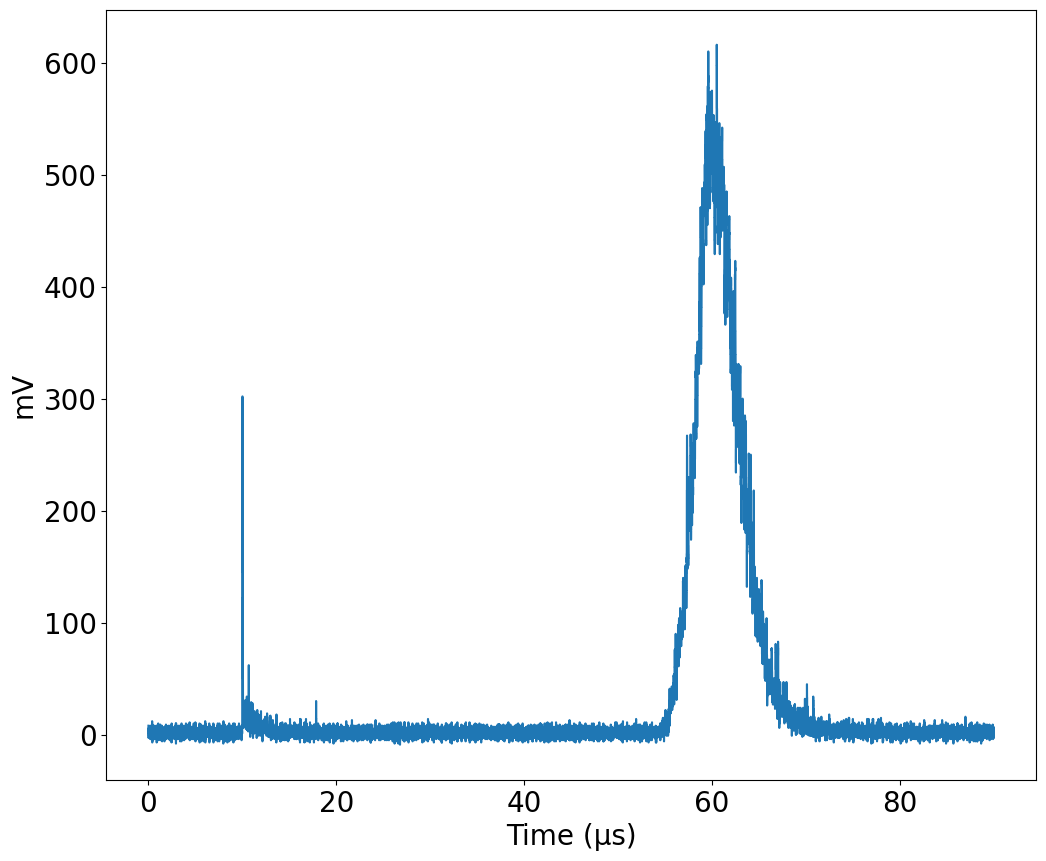

In [3]:
wf_file = '/home/ander/Work/GaP/real_data/241Am/R1102/raw/Run_1102_file_0_raw.h5'

with tb.open_file(wf_file, 'r') as h5in:
    wvfs       =  h5in.root.RD.pmtrwf[1] # Gets all pmt waveforms for the second event in the file
    pmt_rwf    = -wvfs.sum(axis=0)       # Sums and inverts the signal of all PMTs
    t = np.linspace(0, len(pmt_rwf)*8/1000, len(pmt_rwf))
    plt.plot(t, pmt_rwf, drawstyle='steps', lw=1.5, zorder=0)
    plt.xlabel('Time (µs)')
    plt.ylabel('mV')

To calibrate waveforms (conversion from mVns ot pes and baseline subtraction via official reco code) one needs to have installed the gres reconstruction software (clone https://github.com/next-exp/GanESS)

In [4]:
import gres.database.load_db as db
from   gres.cities.components import calibrate_pmts_wf_data

In [5]:
run_number = 1052
n_baseline = 225 # number of time bins to be used for calculating the baseline
n_maw, thr_maw = 250, 0.2 # parameters used for the moving average, only relevant for S1 pmap search
rwf_to_cwf = calibrate_pmts_wf_data("gap", run_number, n_baseline, n_maw, thr_maw) # returns a function to calibrate the waveforms

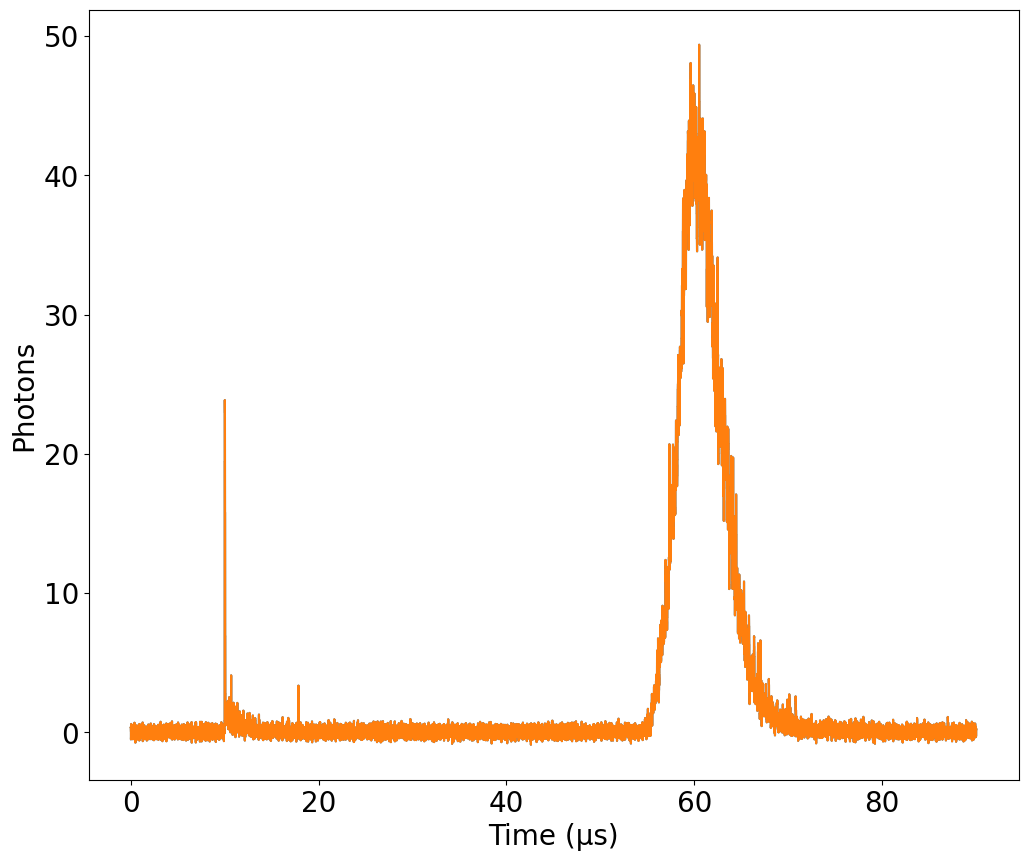

In [6]:
wf_file = '/home/ander/Work/GaP/real_data/241Am/R1102/raw/Run_1102_file_0_raw.h5'

with tb.open_file(wf_file, 'r') as h5in:
    wvfs       =  h5in.root.RD.pmtrwf[1] # Gets all pmt waveforms for the second event in the file
    cwvfs      = rwf_to_cwf(wvfs) # This returns an array of arrays. Index 0 contains individual PMTs, index 2 contains its sum.
    sum_cwvf1  = cwvfs[0].sum(axis=0) # Sums all PMTs
    sum_cwvf2  = cwvfs[2]             # Copies the sum returned by rwf_to_cwf
    t = np.linspace(0, len(sum_cwvf1)*8/1000, len(sum_cwvf2)) # The 8/1000 corresponds to 8 ns time bins
    plt.plot(t, sum_cwvf1, drawstyle='steps', lw=1.5, zorder=0)
    plt.plot(t, sum_cwvf2, drawstyle='steps', lw=1.5, zorder=0)
    plt.xlabel('Time (µs)')
    plt.ylabel('Photons')

# Read reduced dst (WVF)

The reduced datasets of waveforms is a pandas dataframe containing the following information. The

- event     : event id
- timestamp : UNIX timestamp of the event in timebins of 8 ns
- x         : Reconstructed x position (calculated as the weighted average of sensors)
- y         : Reconstructed y position (calculated as the weighted average of sensors)
- r         : Reconstructed radial position (calculated as the weighted average of sensors)
- energy    : Integral of all channels over the full waveform.
- height    : Maximum value of the sum waveform (sum waveform = waveform resulting as the sum of all individual channels waveforms)
- ped\_sum   : Integral of the sum waveform over the region used for baseline calculations.
- e0        : Value of the sum waveform in the first time bin
- s1\_energy : Integral of the sum waveform from t0=0 to t1=n\_s1 parameter in the processing script (39 µs in alpha data)
- s1\_height : Maximum value of the sum waveform from t0=0 to t1=n\_s1 parameter in the processing script (39 µs in alpha data)
- s1\_energy\_islice :  Integral of the sum waveform from t0=9 + 5\*islice to t1=t0+5. islice goes from 0 to 5, to cover from 9 to 39 µs.
- s2\_energy : Integral of the sum waveform from t0=n\_s1 to t1=last time bin
- s2\_energy : Maximum height of the sum waveform from t0=n\_s1 to t1=last time bin
- s1\_t      : Time bin at which the s1\_height is.
- s2\_t      : Time bin at which the s2\_height is.
- t\_all     : Time bin at which the absolute maximum height is.
- e\_pmt*pmtid*    : Integral over the full waveform of PMT with ID *pmtid*
- h\_pmt*pmtid*    : Maximum height in the full waveform of PMT with ID *pmtid*
- e\_pmt*pmtid*_s1 : Integral from t0=0 to t1=n\_s1 of PMT with ID *pmtid*
- h\_pmt*pmtid*_s1 : Maximum height from t0=0 to t1=n\_s1 of PMT with ID *pmtid*
- e\_pmt*pmtid*_s2 : Integral from t0=n\_s1 to t1=last time bin of PMT with ID *pmtid*
- h\_pmt*pmtid*_s2 : Maximum height from t0=n\_s1 to t1=last time bin of PMT with ID *pmtid*
- ped\_sum\_pmt*pmtid*_s2 : Integral of the waveform over the region used for baseline calculations for PMT with ID *pmtid*
- e0\_pmt*pmtid*_s2 : Value of the waveform in the first time bin for PMT with ID *pmtid*
- file : Input file that contains the waveform corresponding to this event.

Note that all charge related variables have been converted into 'photoelectrons' following the calibration constants in the database.

**Important**: There is less information available for 55Fe data as no partition between S1 and S2 is done (no S1 is expected). The *energy* variable should be used as *s2_energy*

They can be read as:

In [3]:
dst_file = '/home/ander/Work/GaP/real_data/241Am/R1511/octavia/DST_run_1511_pmaps.h5'
dst      = pd.read_hdf(dst_file, 'WVF')

The values can be accesed by column name, here an example shows a histogram of the variable *energy* for iron

In [5]:
dst

,event,timestamp,x,y,r,energy,height,ped_sum,e0,s1_energy,...,h_pmt5_s1,ped_sum_pmt5,e0_pmt5,e_pmt6,h_pmt6,e_pmt6_s1,h_pmt6_s1,ped_sum_pmt6,e0_pmt6,file
0,0,89068,0.876721,1.607603,1.831127,1194.904270,6.221990,-5.551115e-16,-0.469161,1073.665222,...,1.358746,1.942890e-16,-0.070713,133.889330,1.326979,130.182685,1.326979,-4.440892e-16,-0.102727,Run_1511_file_0_raw.h5
1,3,115396,2.119949,-0.456634,2.168571,1064.140372,9.234243,6.661338e-16,0.108443,976.898415,...,1.047718,-1.804112e-16,-0.008839,139.096285,1.723767,124.013768,1.564910,5.273559e-16,0.055776,Run_1511_file_0_raw.h5
2,10,131513,3.963572,-1.496371,4.236630,1205.524430,7.662085,2.331468e-15,-0.363609,1067.964014,...,1.175057,3.469447e-16,-0.005801,165.413467,1.251434,153.163887,1.251434,6.106227e-16,-0.098844,Run_1511_file_0_raw.h5
3,17,175975,0.824085,2.645423,2.770808,1308.232181,9.776507,1.387779e-15,-0.118607,1132.831789,...,2.043782,-6.938894e-17,-0.007182,185.155767,1.727650,155.176066,1.727650,5.551115e-17,-0.019769,Run_1511_file_0_raw.h5
4,23,239974,0.422407,-0.717781,0.832849,1061.699446,8.953203,-2.220446e-16,-0.247590,959.302618,...,1.483323,1.387779e-17,-0.008287,128.161680,1.330862,108.763569,1.330862,-5.551115e-17,-0.019416,Run_1511_file_0_raw.h5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,6256170,70240755140,-27.298925,-7.894718,28.417563,-677.761831,2.910026,-1.332268e-15,0.035479,-169.311615,...,0.887232,5.551115e-17,0.017126,32.486100,0.778396,21.604448,0.778396,-4.024558e-16,0.142971,Run_1511_file_9_raw.h5
996,6256188,70240909744,3.811064,1.882196,4.250514,1047.742910,8.529051,2.442491e-15,-0.173439,966.719696,...,2.542642,2.775558e-16,-0.005524,114.173506,2.205278,124.993381,2.205278,2.775558e-16,-0.098138,Run_1511_file_9_raw.h5
997,6256210,70241128832,7.652212,12.547935,14.697177,-53.780168,1.491205,-2.109424e-15,-0.457113,-12.712974,...,0.179546,-1.387779e-16,-0.006906,-29.944400,0.378078,-8.339952,0.378078,-4.440892e-16,-0.098491,Run_1511_file_9_raw.h5
998,6256220,70241332657,1.352514,6.828578,6.961234,905.702041,7.782834,-8.881784e-16,-0.529968,895.376582,...,0.982529,-6.661338e-16,-0.074028,176.392198,1.656694,153.825788,1.656694,-4.996004e-16,-0.170153,Run_1511_file_9_raw.h5


In [8]:
70241448819/1e9*8

561.931590552

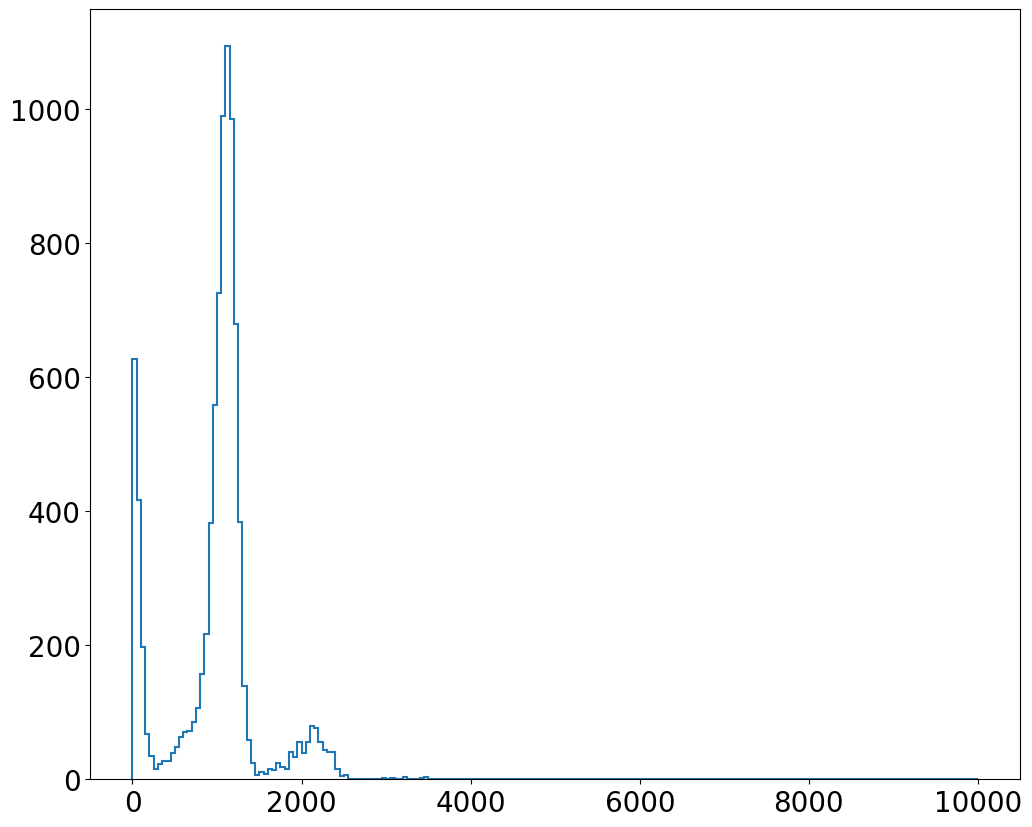

In [4]:
ebins = np.linspace(0, 10000, 201)
plt.hist(dst['energy'], ebins, histtype='step', lw=1.5);

Filters can be applied with boolean arrays. The easiest way to get them is via comparison orders as shown:

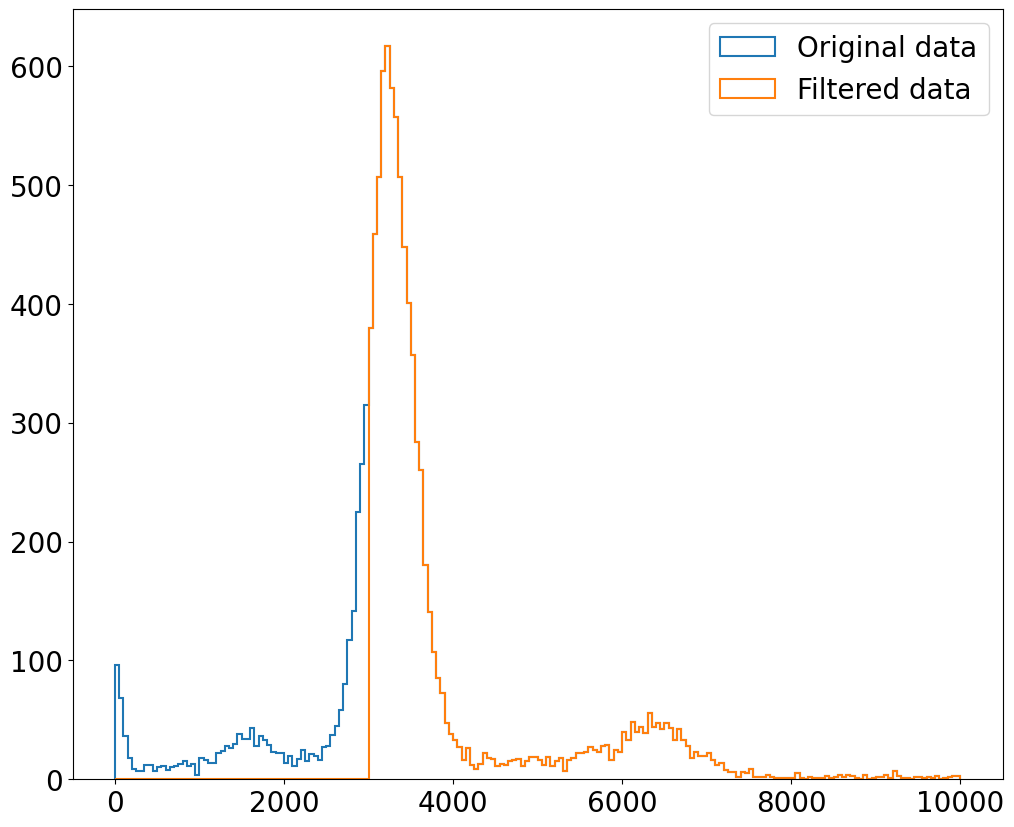

In [9]:
ebins = np.linspace(0, 10000, 201)
plt.hist(dst['energy'], ebins, histtype='step', lw=1.5, label='Original data');

sel_filter = dst['energy'] > 3000
plt.hist(dst['energy'][sel_filter], ebins, histtype='step', lw=1.5, label='Filtered data');

plt.legend()

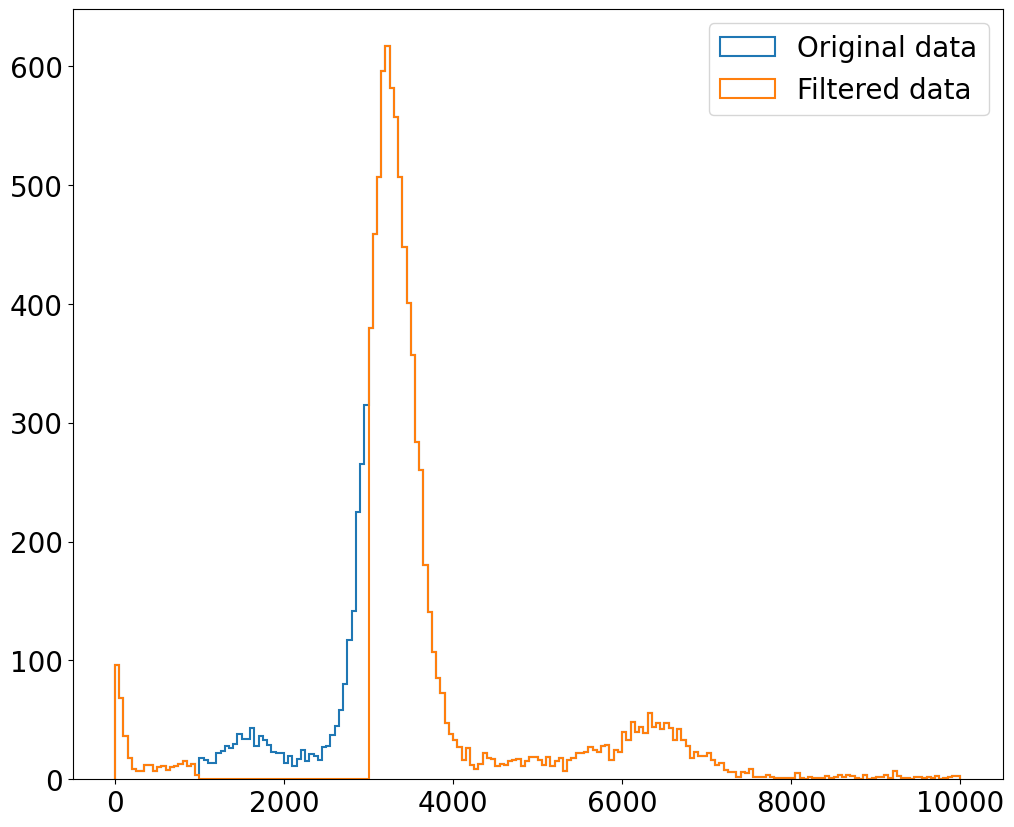

In [11]:
ebins = np.linspace(0, 10000, 201)
plt.hist(dst['energy'], ebins, histtype='step', lw=1.5, label='Original data');

sel_filter = (dst['energy'] > 3000) | (dst['energy'] < 1000)
plt.hist(dst['energy'][sel_filter], ebins, histtype='step', lw=1.5, label='Filtered data');

plt.legend()